# Team Assignment 4: Data Exploration
* **Author**: Matt Williams
* **Date**: 09/24/2024
* **Dataset URL**: https://github.com/Welltory/hrv-covid19
* **Raw data location**: https://github.com/Welltory/hrv-covid19/tree/master/data
* **Execution**: within Jupyter Notebook, click "Run All" to have all code results displayed or execute each code cell individually as you encounter them.
* **Viewing tip**: if you're viewing this notebook with Visual Studio code, ensure the Outline view (_View -> Open View..._) is displayed for easier navigation. 
  * Reference: https://code.visualstudio.com/docs/datascience/jupyter-notebooks#_table-of-contents

## Data Context
### Data Collection
[Welltory](https://welltory.com/our-story/) is a company that owns a health and fitness mobile application of the same name that "_lets you sync data from other apps & gadgets for more insights about your health and lifestyle._<sup>1</sup>" As part of their COVID-19 research in 2020, Welltory invited users who tested positive for COVID-19 to "_share the progress of their symptoms, and body vitals including the [HRV]((https://en.wikipedia.org/wiki/Heart_rate_variability)) collected by wearables like Apple Watch, Garmin, and Fitbit in collaboration with the Welltory mobile application._<sup>2</sup>" To measure HRV, wrist-worn monitors such as the Apple Watch use "_a combination of LED lights and sensitive photo-diodes as a part of the PhotoPlethysmoGraphy (PPG) process._<sup>2</sup>"

### Known Biases or Limitations
The dataset suffers from two types of selection bias: coverage bias and participation bias. Coverage bias is introduced as a byproduct of participants being limited to users of the Welltory app. It's reasonable to assume users of a health and fitness app (Welltory) are younger and healthier than the average person and therefore may experience COVID-19 differently from other populations. Older members of the population are less likely to utilize a smartphone app to track their health and fitness and, as a result, their age group may be underrepresented in the dataset. This will be explored later in the report.

Another instance of selection bias is called out in _Wearable Devices, Smartphones, and Interpretable Artificial Intelligence in Combating COVID-19_<sup>3</sup>, which notes "_...most participants are from Russia and United States._"  _Pre-Emption of Affliction_<sup>2</sup> also noted the "_absence of cases where participants had recovered and contracted SARS-Cov-2 again also left opportunities for future research._"

Participation bias may be present due to the volunteer-like aspect of Welltory app users reporting their symptoms. As noted in _Pre-Emption of Affliction_<sup>2</sup>, "_...some participants had reported symptoms and HRV measurements diligently, many other participants did not log SARS-Cov-2 symptoms for more than a few days_". This may have introduced a bias toward more diligent, and therefore potentially healthier, individuals.

One notable limitation was data collection being cut short in 2020 due to "_new laws that forbade the release of mobile applications with titles containing Covid-related terms._<sup>2</sup>"

### Relationship to the Problem
The dataset contains HRV measurements and other body vitals that could be used to measure or identify the following<sup>4</sump>:

* COVID-19 patterns
* Early diagnostics
* Psychosomatic detection
* Response to treatment
* Signs of recovery
* Identifying critical conditions


## Data Sampling

### Representation
The population of interest is presumed to be individuals currently infected with COVID-19. However, for the reasons identified in the _Known Biases and Limitations_ section above, we can't reasonably assume the population of Welltory app users that participated is representative of the larger worldwide population of COVID-19 patients.

### Training and Test Sets
With no known external test set, the dataset should be split for training, validation, and testing.

### Segmentation
The dataset is separated into the CSV files listed below.
* `blood_pressure.csv`
* `heart_rate.csv`
* `hrv_measurements.csv`
* `participants.csv`
* `sleep.csv`
* `surveys.csv`
* `wearables.csv`
* `weather.csv`

The `participants.csv` file contains a `user_code` column that is also present in every other CSV file and therefore acts as a "primary key". This allows dataset users to combine two or more relevant segments of the data for the problem they're trying to solve. As such, each CSV utilized for training purposes should be examined before it is potentially combined with other CSV data.

The dataset also includes an additional CSV file (`scales_description.csv`) that enumerates possible values for COVID symptoms and user health attributes (e.g., "_Whether the user has high cholesterol_"). For COVID symptoms, _When Patients Recover From COVID-19: Data-Driven Insights From Wearable Technologies_<sup>5</sup> points out "..._we also selected ordered categorical variables with values from 1 to 6 recording the intensity of seven common COVID-19 symptoms that were in the HRV survey dataset: breath, confusion, cough, fatigue, fever, pain, and bluish._"


## Data Import

### Import required libraries

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Increase display width
pd.set_option('display.width', 1000)

### Import the dataset

In [20]:
# URL of the directory that contains the CSV files 
directory_url = "https://raw.githubusercontent.com/Welltory/hrv-covid19/refs/heads/master/data/"

# Names of CSV files in the dataset; `scales_description` omitted because it simply functions as a "key"
csv_names = ["participants",
             "blood_pressure",
             "heart_rate",
             "hrv_measurements",
             "sleep",
             "surveys",
             "wearables",
             "weather"]


# Convert date strings in the form MM/DD/YYYY to np.datetime64
def convert_MM_DD_YYYY_to_datetime64(date_str) -> np.datetime64 | None:
    if date_str:
        date_str = datetime.datetime.strptime(date_str, "%m/%d/%Y").strftime("%Y-%m-%d")
        return np.datetime64(date_str)


# Converts date/time strings in the form YYYY-MM-DD or YYYY-MM-DD hh:mm:ss to np.datetime64
def convert_datetime_to_datetime64(datetime_str) -> np.datetime64:
    # Some values include a double space between YYYY-MM-DD and hh:mm:ss
    return np.datetime64(datetime_str.replace("  ", " "))


# Mapping of columns that contain dates or datetimes to be converted to np.datetime64
conversion_mappings = {
    "participants":       {"symptoms_onset": convert_MM_DD_YYYY_to_datetime64},
    "hrv_measurements":   {"measurement_datetime": convert_datetime_to_datetime64},
    "blood_pressure":     {"measurement_datetime": convert_datetime_to_datetime64},
    "heart_rate":         {"datetime": convert_datetime_to_datetime64},
    "wearables":          {"day": convert_datetime_to_datetime64},
    "sleep":              {"day": convert_datetime_to_datetime64,
                           "sleep_begin": convert_datetime_to_datetime64,
                           "sleep_end": convert_datetime_to_datetime64},
    "weather":            {"day": convert_datetime_to_datetime64},
    "surveys":            {"created_at": convert_datetime_to_datetime64}
}

# Import each CSV file into its own dataframe
# Store the dataframe as a value in a dictionary named `dataframes` whose keys correspond to the `csv_names` defined above.
dataframes = {}
for csv_name in csv_names:
    # If the CSV contains date and/or datetime columns
    if csv_name in conversion_mappings:
        # Convert the date and/or datetime columns to np.datetime64 using the proper converter function
        dataframes[csv_name] = pd.read_csv(f"{directory_url}{csv_name}.csv",
                                           converters=conversion_mappings.get(csv_name))
    else:
        dataframes[csv_name] = pd.read_csv(f"{directory_url}{csv_name}.csv")

    # For `heart_rate.csv`, convert the `is_resting` column to a boolean value
    if csv_name == "heart_rate":
        dataframes[csv_name] = dataframes[csv_name].astype({"is_resting": "bool"})

## Data Structure
The dataset's Github repository [includes a page](https://github.com/Welltory/hrv-covid19/blob/master/datatypes.md) that describes each CSV file and the data types defined therein. The page contains two notable errors: the sleep duration values (e.g., `sleep_deep_duration`) in `sleep.csv` are given in seconds instead of hours and a column in `heart_rate.csv` is incorrectly given (should be `datetime` instead of `daytime`).

The Python code below generates a report outlining elements of the data's structure.

In [3]:
for df_name, df in dataframes.items():
    print(f"\n\nData Structure - {df_name}.csv")
    print("------------------------------")
    print("Dimensions:\n")
    print(f"    Rows: {df.shape[0]}")
    print(f"    Columns: {df.shape[1]}")
    print(f"\nData Types:\n\n{df.dtypes}")
    print(f"\nMissing Values:\n\n{df.isnull().sum()}")



Data Structure - participants.csv
------------------------------
Dimensions:

    Rows: 185
    Columns: 8

Data Types:

user_code                 object
gender                    object
age_range                 object
city                      object
country                   object
height                   float64
weight                   float64
symptoms_onset    datetime64[ns]
dtype: object

Missing Values:

user_code          0
gender             0
age_range          0
city              12
country            6
height             2
weight             0
symptoms_onset    38
dtype: int64


Data Structure - blood_pressure.csv
------------------------------
Dimensions:

    Rows: 721
    Columns: 8

Data Types:

user_code                           object
measurement_datetime        datetime64[ns]
diastolic                            int64
systolic                             int64
functional_changes_index           float64
circulatory_efficiency             float64
kerdo_vegetation_

### Interpretation
The dataset contains information collected from 185 participants with a wide range of numerical features that are described on [this Github page](https://github.com/Welltory/hrv-covid19/blob/master/datatypes.md). As shown above, multiple segments of the dataset contain missing values that are represented as `NaN`:
* `blood_pressure.csv`
* `hrv_measurements.csv`
* `participants.csv` (notably the `city` and `symptoms_onset` columns)
* `sleep.csv`
* `wearables.csv`

_When Patients Recover..._<sup>5</sup> calls out missing values "_due to the network issues when the data is collected or the users choose not to answer some survey questions for any reason._" _Wearable Devices..._<sup>3</sup> also mentions less than "_60% had consistent readings and a relatively established baseline in their healthy time (over two weeks)._"

To handle missing values in `participants.csv`, for example, one might consider removing the `city` feature altogether, especially considering the `country` feature is present for most participants. Also, as discussed previously, most participants are from only two countries, which might heavily skew interpretations based on these features. As for the `symptoms_onset` column, which is missing for 38/185 participants, one possible solution is to use the data from `surveys.csv` to determine when each participant began reporting COVID symptoms.

## Descriptive Statistics
The following Python code generates a Descriptive Statistics report for the dataset.

In [21]:
for df_name, df in dataframes.items():
    print(f"\n\nDescriptive Statistics - {df_name}.csv")
    print("------------------------------")
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    print("Central Tendency Measures:\n")
    print(df[numeric_columns].describe().loc[['mean', '50%']])
    print("\nDispersion Measures:\n")
    print(df[numeric_columns].describe().loc[['std', 'min', 'max']])

    # Check for distribution normality (skewness and kurtosis)
    print(f"\nDistribution Measures - {df_name}.csv")
    print("------------------------")
    print("Skew:\n")
    print(df[numeric_columns].skew())
    print("\nKurtosis:\n")
    print(df[numeric_columns].kurt())



Descriptive Statistics - participants.csv
------------------------------
Central Tendency Measures:

          height     weight
mean  169.976393  77.927757
50%   168.000000  74.344000

Dispersion Measures:

         height      weight
std   12.400103   19.552541
min  132.080000   43.500000
max  250.000000  154.221000

Distribution Measures - participants.csv
------------------------
Skew:

height    2.910275
weight    0.865345
dtype: float64

Kurtosis:

height    17.552808
weight     0.891368
dtype: float64


Descriptive Statistics - blood_pressure.csv
------------------------------
Central Tendency Measures:

      diastolic    systolic  functional_changes_index  circulatory_efficiency  kerdo_vegetation_index  robinson_index
mean  81.228849  119.441054                  2.594013             2735.197057              -15.498233       84.663779
50%   82.000000  120.000000                  2.580000             2640.000000              -17.000000       83.220000

Dispersion Measures:

  

### Interpretation
**Descriptive Statistics**
The mean and median provide insights into the central location of the data. For example, from `heart_rate.csv`, the mean `heart_rate` is around 91 bpm, and the median is around 87 bpm, indicating a roughly symmetric distribution. Ignoring columns that require domain-specific knowledge (e.g., `circulatory_efficiency`), one segment of the data stood out as having columns with non-symmetrical distributions: `wearables.csv`. For example, the mean `steps_count` per day is approximately 5,342 but the median `steps_count` is 4,477. As one might expect, the same can be said for the `distance` column (3,494 vs. 2,687).

**Dispersion Measures**
These measures give us an understanding of the spread and range of the data. For instance, from `heart_rate.csv`, the standard deviation of `heart_rate` is about 25 bpm, indicating a typical deviation from the mean. These measurements also show possible anomalies. For example, a maximum `heart_rate` value of 232 bpm is present. While possible, this measurement seems quite high given the target maximum heart rate is typically computed by subtracting one's age from 220. Values like this may warrant further investigation.

**Distribution Measures**
Skewness values close to 0 indicate a symmetric distribution, while positive or negative values indicate right or left skew, respectively. Kurtosis indicates the "tailedness" of the distribution; values close to 0 suggest a normal distribution, while higher values suggest heavier tails. To illustrate skewness, consider the value of participant height, which ranges from 132 cm (4ft 4in) to 250 cm (8ft 2in). The average height of an adult male is around 5ft 9in and the average height of an adult female is 5ft 4in. In the dataset, the mean and median height are roughly 5ft 6in. Due to more taller-than-average participants than shorter-than-average participants, including two participants that are taller than 8 ft (see five tallest participants below), the data has a positive skew value (2.9). This means the tail of the height distribution bends down and to the right towards the taller participants. This distribution is illustrated in a chart below.

In [23]:
# Display the five tallest participants
print("Five Tallest Participants:")
dataframes["participants"].sort_values(by="height", ascending=False).head(5)

Five Tallest Participants:


,user_code,gender,age_range,city,country,height,weight,symptoms_onset
102,83161408c1,m,25-34,Kurdistan,Iraq,250.00,82.146,1993-01-01
49,3fff7627ca,m,35-44,Fountain Hill,United States,248.92,114.713,1984-04-05
83,6ce06ce747,m,35-44,St Petersburg,Russia,203.00,70.534,NaT
175,f8b552df37,m,45-54,Moscow,Russia,193.00,90.000,2020-04-25
136,b3c7f65a4b,m,18-24,Bullard,United States,193.00,65.998,2000-06-07


To illustrate kurtosis, let's continue with the height example. A higher value in this case (17.5) indicates the height curve has a sharp peak. This is illustrated by the histogram below, which also shows the right-skew of the height values.

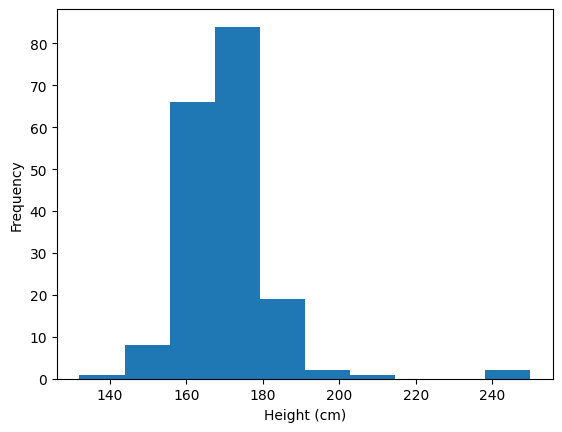

In [6]:
# Histogram of participant height
dataframes["participants"]["height"].plot.hist()
plt.xlabel("Height (cm)")
plt.show()

The box plot below also highlights the extreme height outliers discussed above.

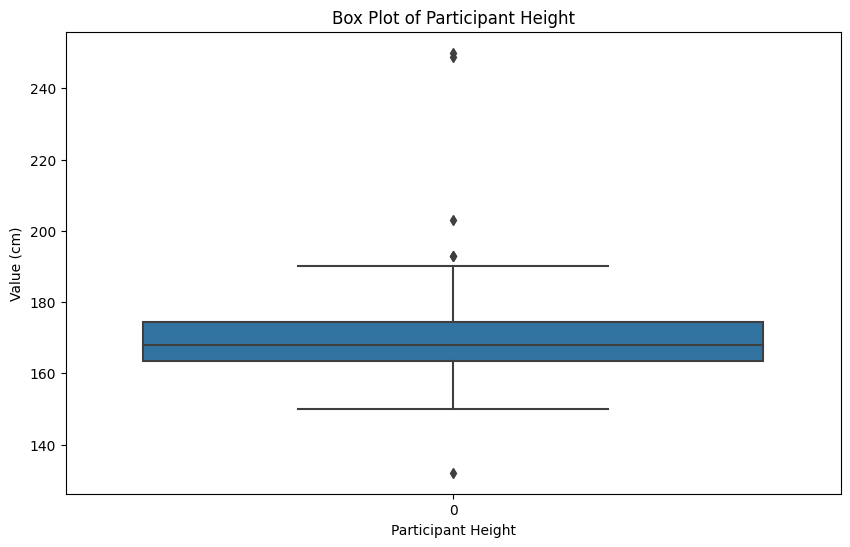

In [7]:
# Box plot of participant height
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataframes["participants"]["height"])
plt.title(f"Box Plot of Participant Height")
plt.ylabel("Value (cm)")
plt.xlabel("Participant Height")
plt.show()

## Data Quality
The Python code below generates metadata that can be used to assess the quality of the dataset.

In [8]:
for df_name, df in dataframes.items():
    print(f"\n\nData Quality - {df_name}.csv")
    print("------------------------------")
    print(f"Duplicated Rows: {df.duplicated().sum()}\n")
    print("Checking for Inconsistent Values:\n")
    print(df.apply(lambda x: x.value_counts().index[0]).to_frame('most_frequent_value'))

    date_columns = df.select_dtypes(include=[np.datetime64]).columns
    print(f"\nChecking for Date/Time Abnormalities:\n")
    print(df[date_columns].describe())



Data Quality - participants.csv
------------------------------
Duplicated Rows: 0

Checking for Inconsistent Values:

                most_frequent_value
user_code                007b8190cf
gender                            f
age_range                     35-44
city                         Moscow
country                      Russia
height                        168.0
weight                         60.0
symptoms_onset  2020-05-06 00:00:00

Checking for Date/Time Abnormalities:

                      symptoms_onset
count                            147
mean   2017-07-18 04:04:53.877551104
min              1967-01-30 00:00:00
25%              2020-03-22 12:00:00
50%              2020-04-10 00:00:00
75%              2020-04-29 00:00:00
max              2022-04-21 00:00:00


Data Quality - blood_pressure.csv
------------------------------
Duplicated Rows: 0

Checking for Inconsistent Values:

                          most_frequent_value
user_code                          a1c2e6b2eb
measur

As a data integrity measure, the following Python code verifies no `user_code` values were duplicated:

In [24]:
# The number of unique identifiers matches the number of participants in `participants.csv`
if len(pd.unique(dataframes["participants"]["user_code"])) == len(dataframes["participants"]):
    print("No duplicate user_code values present.")
else:
    print("Duplicate user_code value detected.")

No duplicate user_code values present.


### Interpretation
The dataset does not contain any duplicated rows. One abnormality exists in `participants.csv`: the `symptoms_onset` column. The following is a selection from the `participants.csv` output above:
```
                      symptoms_onset
count                            147
mean   2017-07-18 04:04:53.877551104
min              1967-01-30 00:00:00
25%              2020-03-22 12:00:00
50%              2020-04-10 00:00:00
75%              2020-04-29 00:00:00
max              2022-04-21 00:00:00
```

This summary shows a minimum `symptoms_onset` date of `1967-01-30`, which is an obvious error. The same can be said for the `mean` value, which should not be earlier than 2020. One possible explanation is users mistakenly entered their date of birth instead of the symptom onset date.

## Variable Relationships
To identify variable relationships, the Python code below generates a correlation matrix and correlation heatmap for each CSV file.



Variable Relationships - participants.csv
------------------------------
Correlation Matrix:

          height    weight
height  1.000000  0.227413
weight  0.227413  1.000000


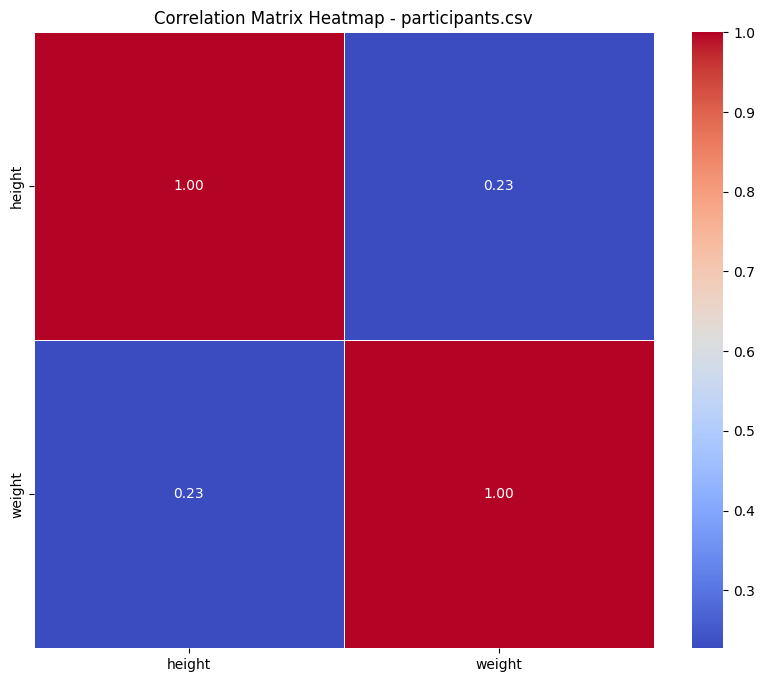



Variable Relationships - blood_pressure.csv
------------------------------
Correlation Matrix:

                          diastolic  systolic  functional_changes_index  circulatory_efficiency  kerdo_vegetation_index  robinson_index
diastolic                  1.000000  0.581326                  0.642446               -0.210696               -0.508497        0.395594
systolic                   0.581326  1.000000                  0.681542                0.571077               -0.383702        0.481670
functional_changes_index   0.642446  0.681542                  1.000000                0.438337                0.010715        0.786682
circulatory_efficiency    -0.210696  0.571077                  0.438337                1.000000                0.449225        0.657004
kerdo_vegetation_index    -0.508497 -0.383702                  0.010715                0.449225                1.000000        0.472052
robinson_index             0.395594  0.481670                  0.786682               

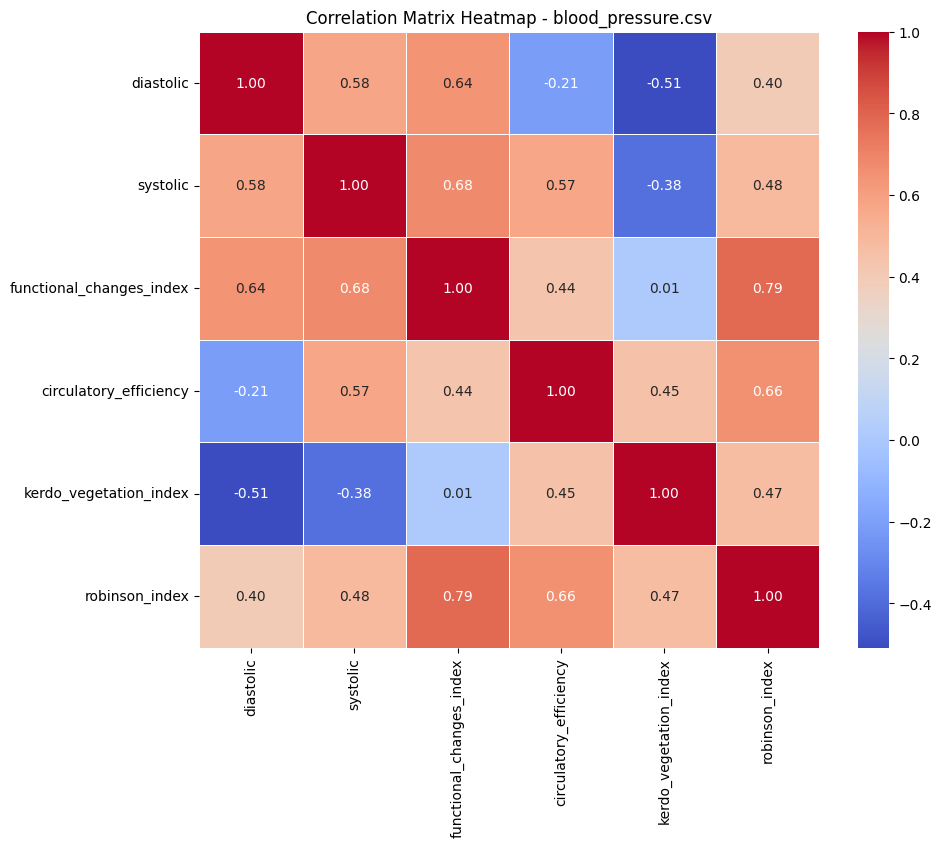



Variable Relationships - hrv_measurements.csv
------------------------------
Correlation Matrix:

                  bpm    meanrr     mxdmn      sdnn     rmssd     pnn50      mode       amo        lf        hf       vlf      lfhf  total_power  how_feel  how_mood  how_sleep
bpm          1.000000 -0.977724 -0.343935 -0.341514 -0.214339 -0.408006 -0.956984  0.547373 -0.171505 -0.105204 -0.240630 -0.003373    -0.184698 -0.078663 -0.032198  -0.113765
meanrr      -0.977724  1.000000  0.348015  0.348052  0.231696  0.445640  0.979400 -0.533668  0.176511  0.128630  0.242066 -0.024851     0.201795  0.085541  0.034346   0.099064
mxdmn       -0.343935  0.348015  1.000000  0.954639  0.846259  0.777242  0.262628 -0.750213  0.717783  0.740832  0.491447  0.027057     0.848769  0.103378  0.083491   0.073399
sdnn        -0.341514  0.348052  0.954639  1.000000  0.909046  0.810236  0.258114 -0.759049  0.743380  0.773958  0.489891 -0.022080     0.879030  0.088479  0.062567   0.041479
rmssd       -0.21433

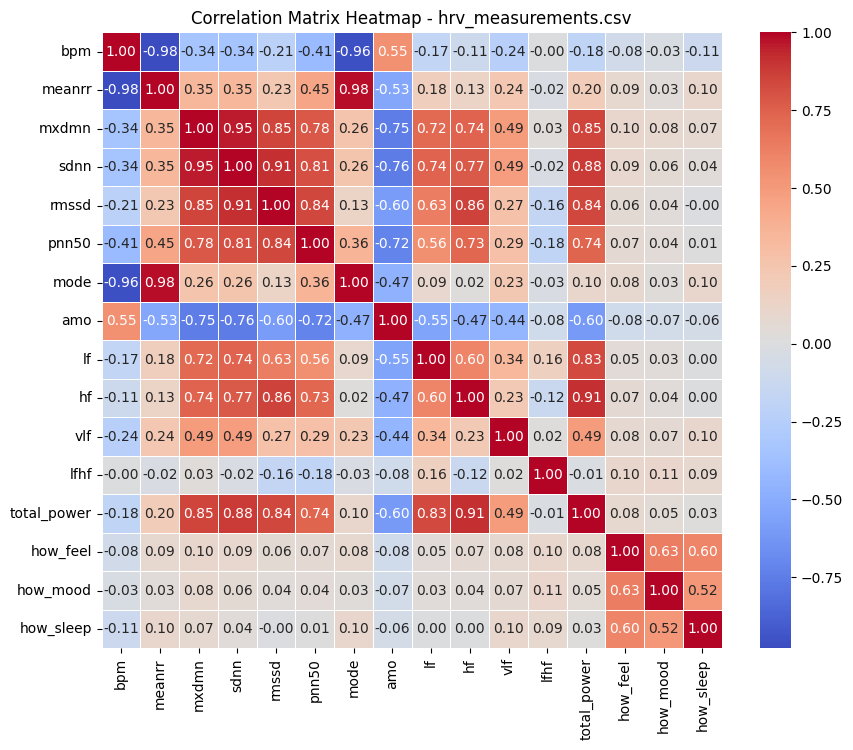



Variable Relationships - sleep.csv
------------------------------
Correlation Matrix:

                      sleep_duration  sleep_awake_duration  sleep_rem_duration  sleep_light_duration  sleep_deep_duration  pulse_min  pulse_max  pulse_average
sleep_duration              1.000000             -0.176436            0.962985              0.409195             0.551536   0.286882   0.542304       0.243608
sleep_awake_duration       -0.176436              1.000000           -0.382577              0.466358             0.283719  -0.937728  -0.999860      -0.935125
sleep_rem_duration          0.962985             -0.382577            1.000000              0.754172             0.977027        NaN        NaN            NaN
sleep_light_duration        0.409195              0.466358            0.754172              1.000000             0.670115  -0.007326  -0.086539      -0.008767
sleep_deep_duration         0.551536              0.283719            0.977027              0.670115             1.0

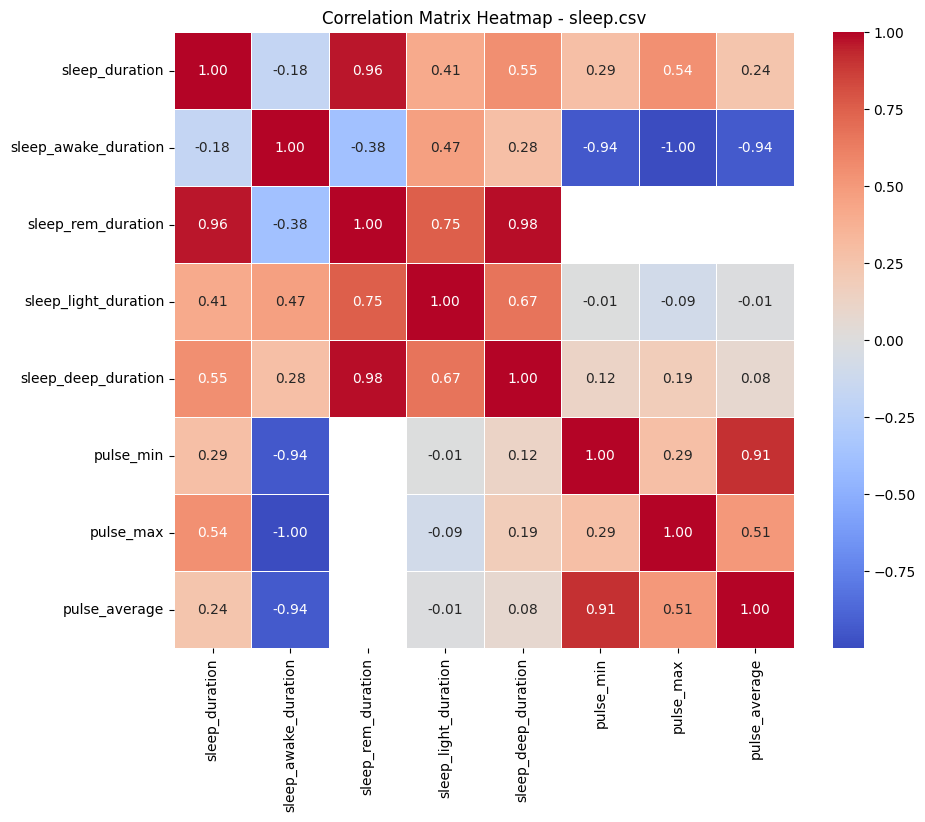



Variable Relationships - wearables.csv
------------------------------
Correlation Matrix:

                                 resting_pulse  pulse_average  pulse_min  pulse_max  average_spo2_value  body_temperature_avg  stand_hours_total  steps_count  distance  steps_speed  total_number_of_flights_climbed  active_calories_burned  basal_calories_burned  total_calories_burned  average_headphone_exposure  average_environment_exposure
resting_pulse                         1.000000       0.338089   0.840694  -0.227967            0.235886             -0.156849          -0.078295    -0.122994 -0.159283     0.125197                        -0.292782                0.481266               0.115074               0.250678                   -0.159091                      0.185576
pulse_average                         0.338089       1.000000   0.315410   0.663218           -0.056980             -0.027397           0.196996     0.130591  0.134463    -0.010898                        -0.069213          

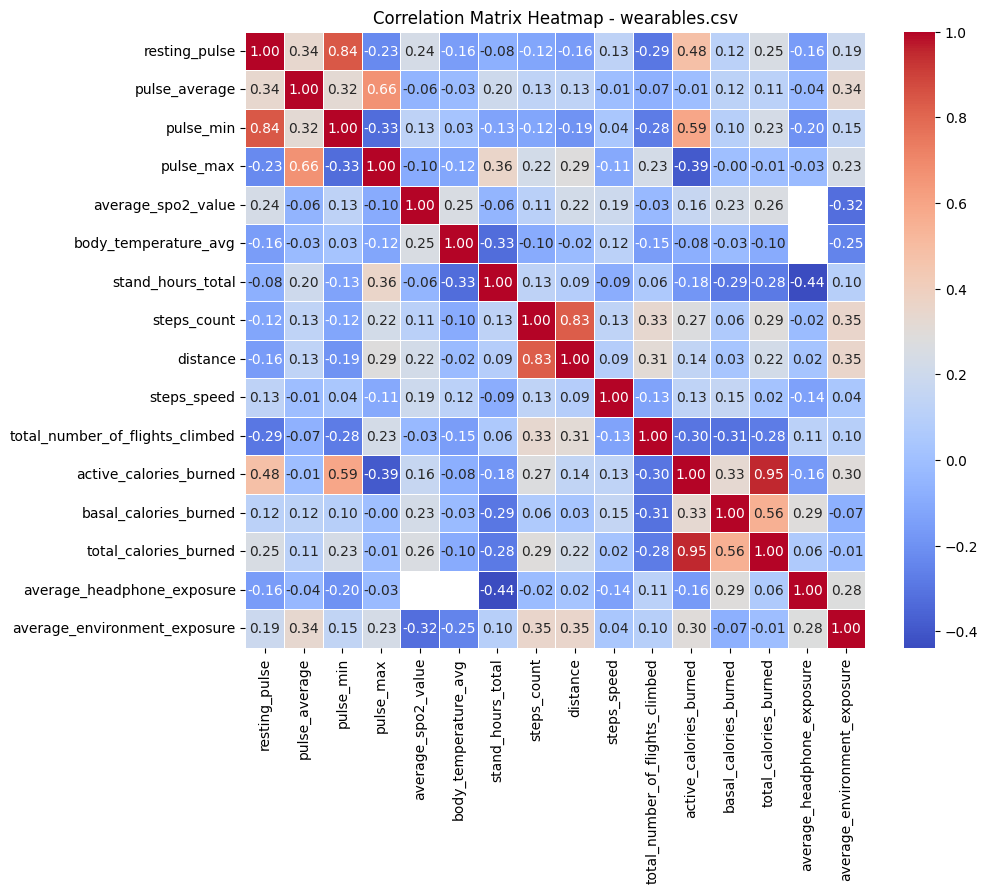



Variable Relationships - weather.csv
------------------------------
Correlation Matrix:

                      avg_temperature_C  atmospheric_pressure  precip_intensity  humidity    clouds
avg_temperature_C              1.000000             -0.002708          0.030620 -0.449895 -0.155868
atmospheric_pressure          -0.002708              1.000000         -0.145488 -0.112873 -0.288340
precip_intensity               0.030620             -0.145488          1.000000  0.230269  0.209718
humidity                      -0.449895             -0.112873          0.230269  1.000000  0.399211
clouds                        -0.155868             -0.288340          0.209718  0.399211  1.000000


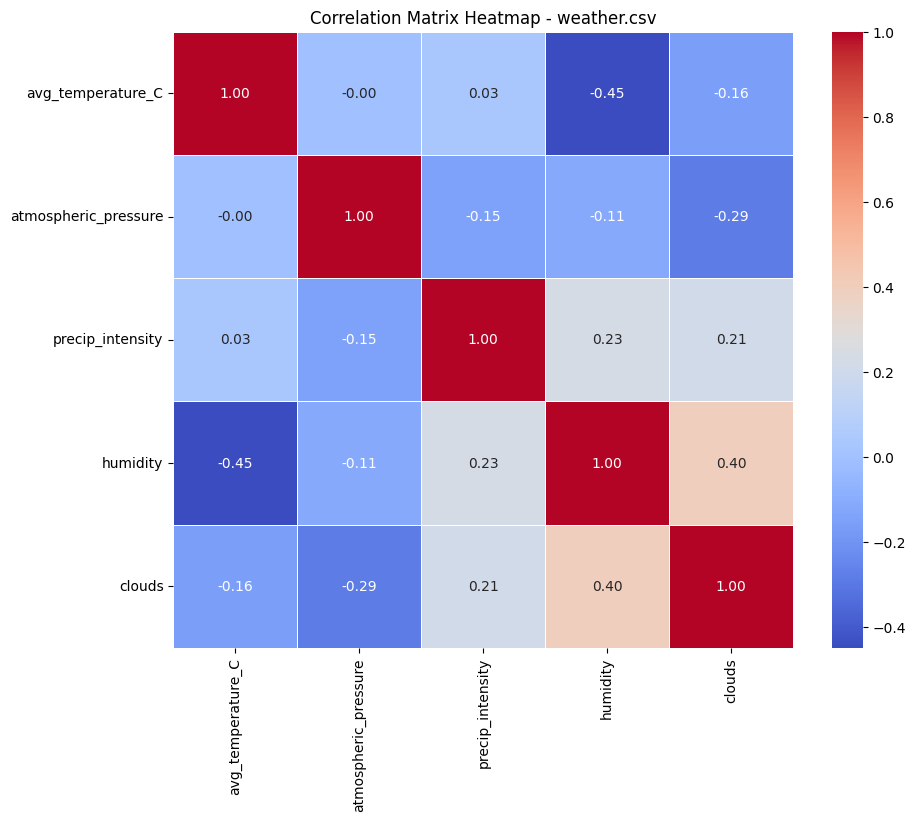

In [10]:
for df_name, df in dataframes.items():
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    # Ignore dataframes with only a single numeric column
    if len(numeric_columns) == 1:
        continue
    
    print(f"\n\nVariable Relationships - {df_name}.csv")
    print("------------------------------")
    print("Correlation Matrix:\n")
    correlation_matrix = df[numeric_columns].corr()
    print(correlation_matrix)

    # Visualize the Correlation Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title(f'Correlation Matrix Heatmap - {df_name}.csv')
    plt.show()

### Interpretation
Focusing on areas that do not require domain knowledge, the `hrv_measurements.csv` heatmap contains an expected positive correlation between the following data points:
* `how_feel`: "How do you feel physically?"
* `how_mood`: "How is your mood?"
* `how_sleep`: "How did you sleep?"

The lowest correlation values between these fields is `0.52`, which suggests that, for example, higher sleep quality results in a better mood and better physical feeling.

To illustrate a negative correlation, the `weather.csv` heatmap also contains an expected negative correlation (`-0.45`): average temperature and humidity. As the average temperature increases, humidity decreases<sup>6</sup>.



## Data Visualization
The Python code below generates data visualizations based on numeric columns within each CSV for the purposes of identifying interesting patterns and insights, which are called out in subsequent cells.

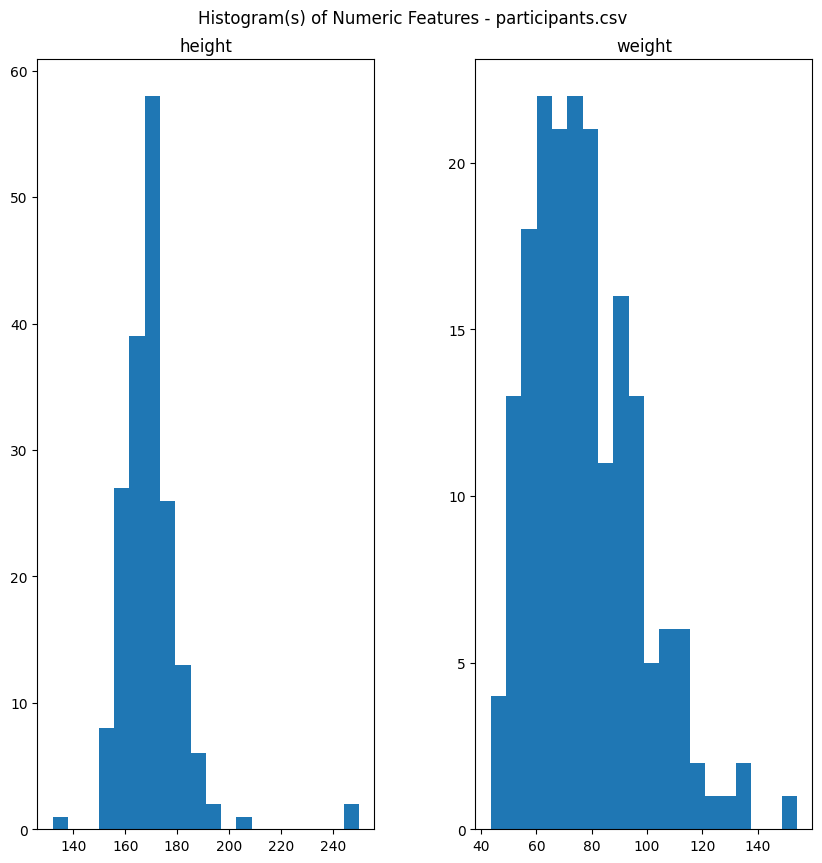

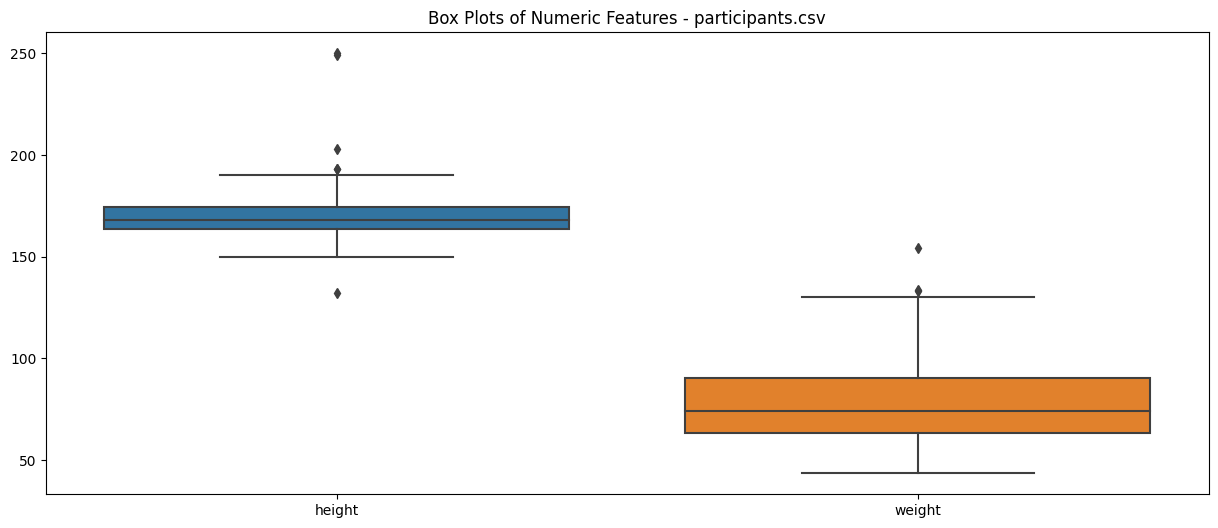

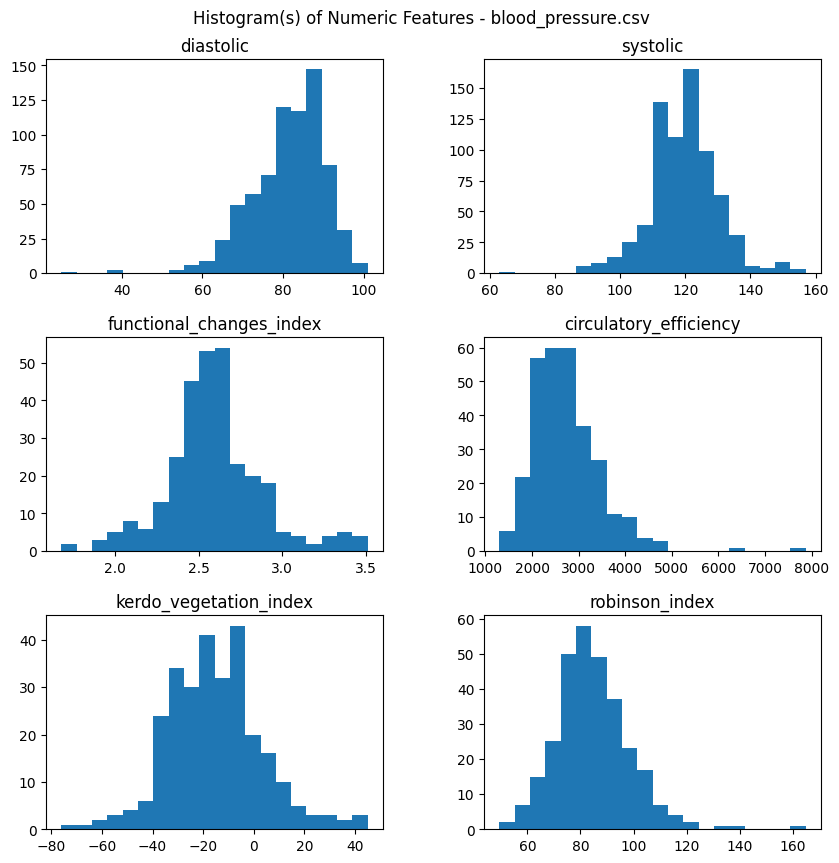

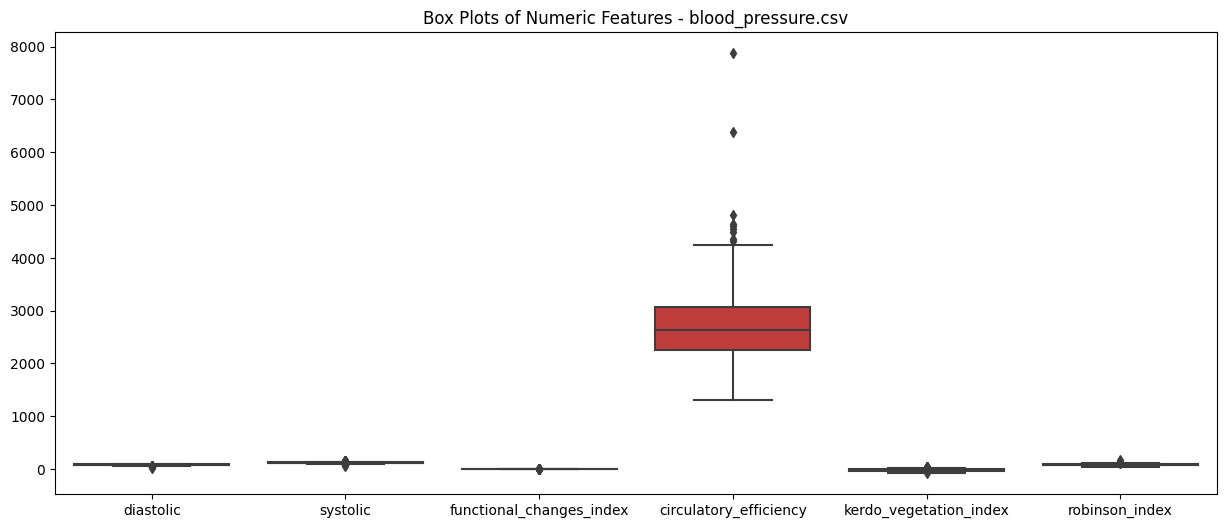

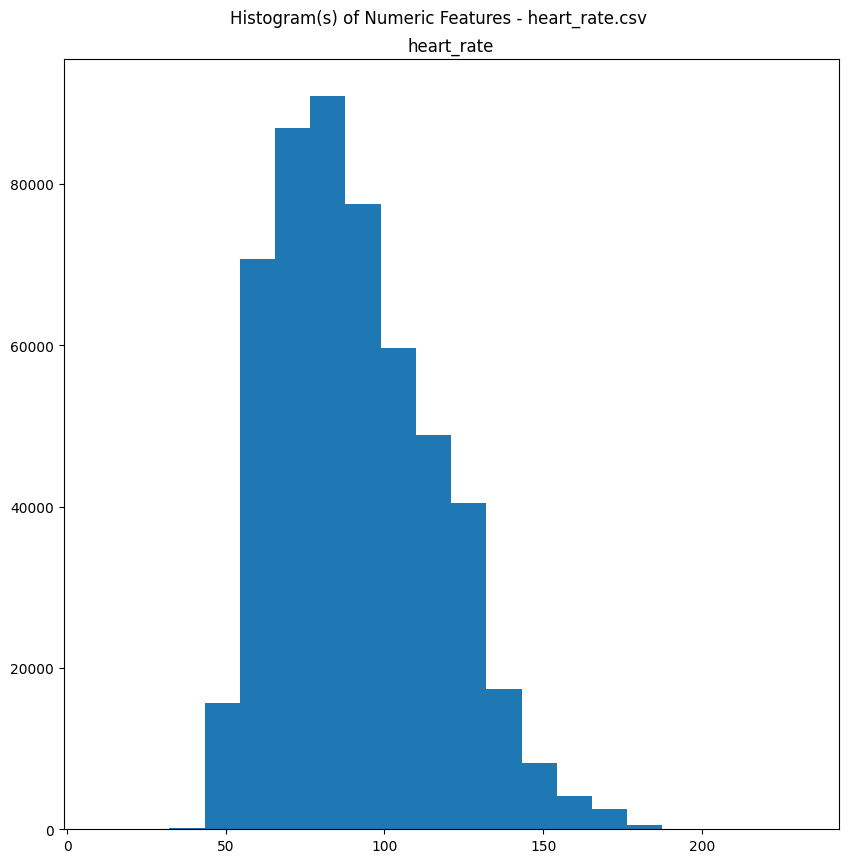

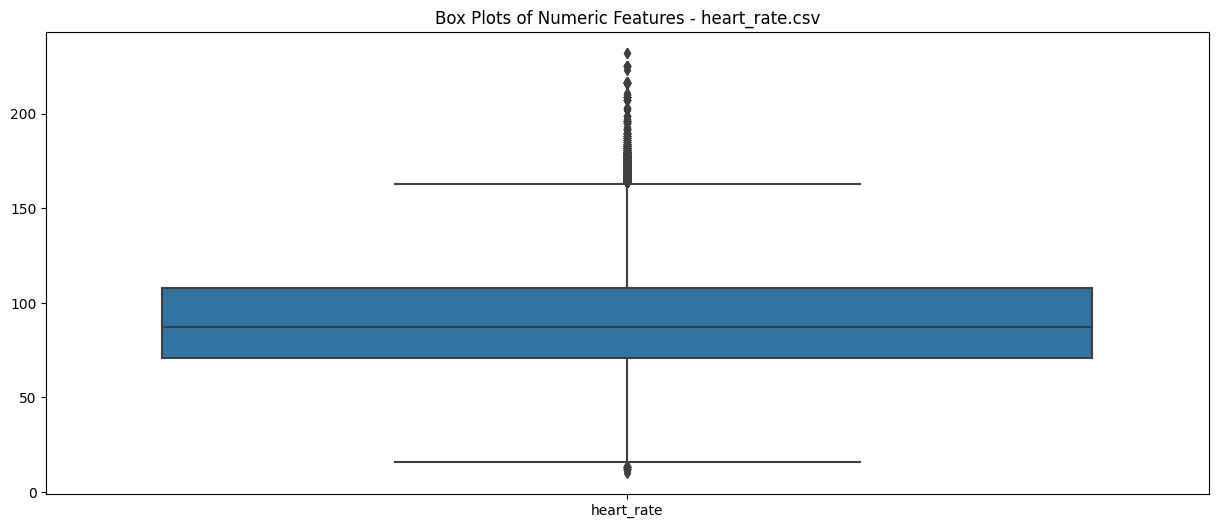

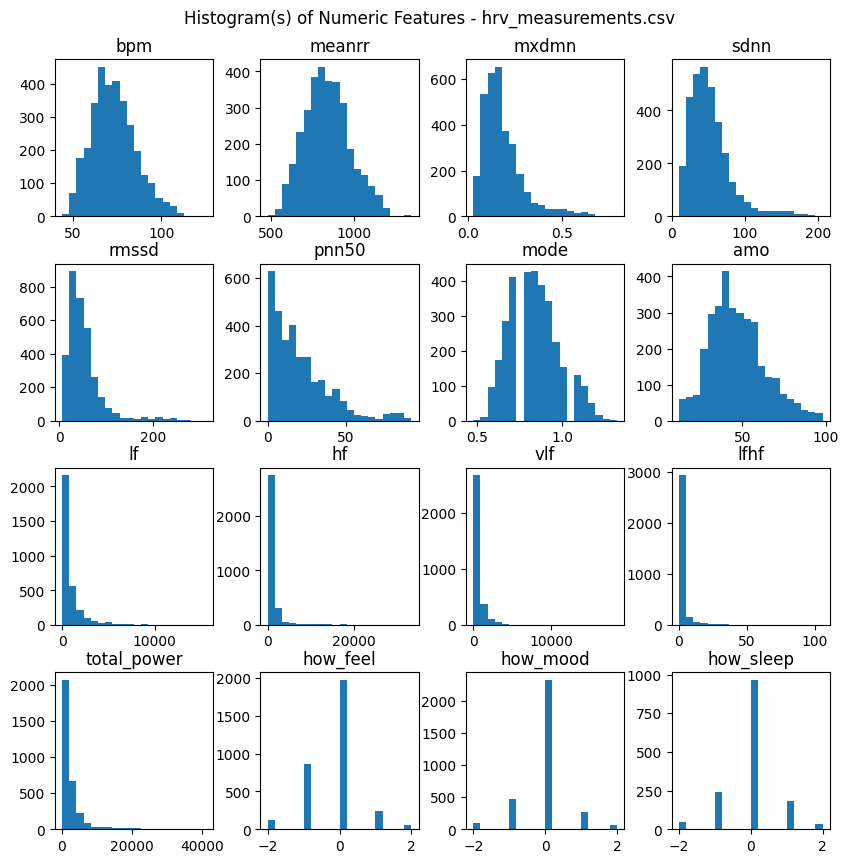

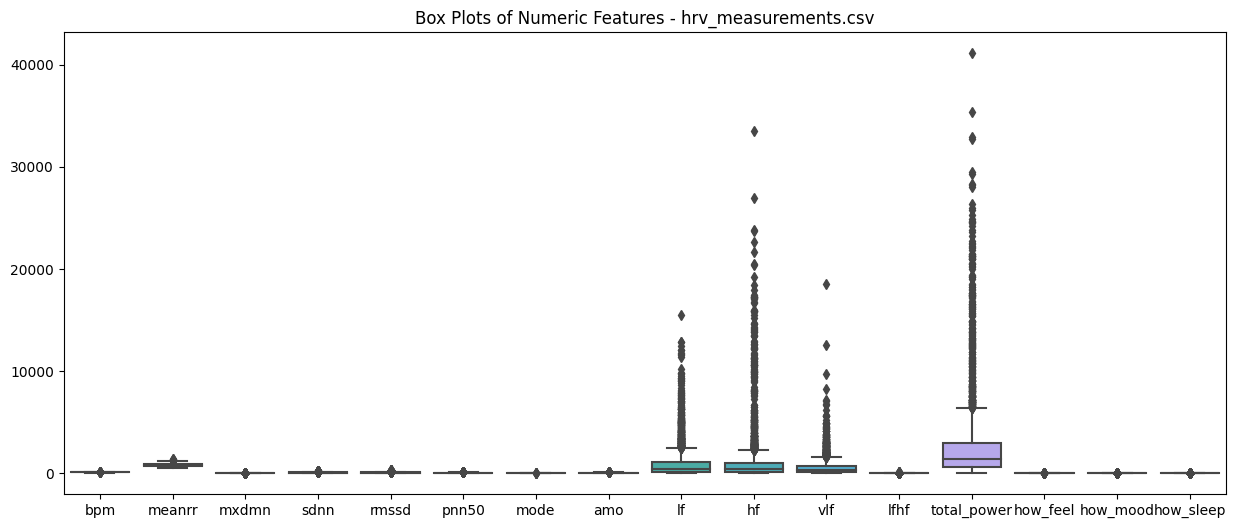

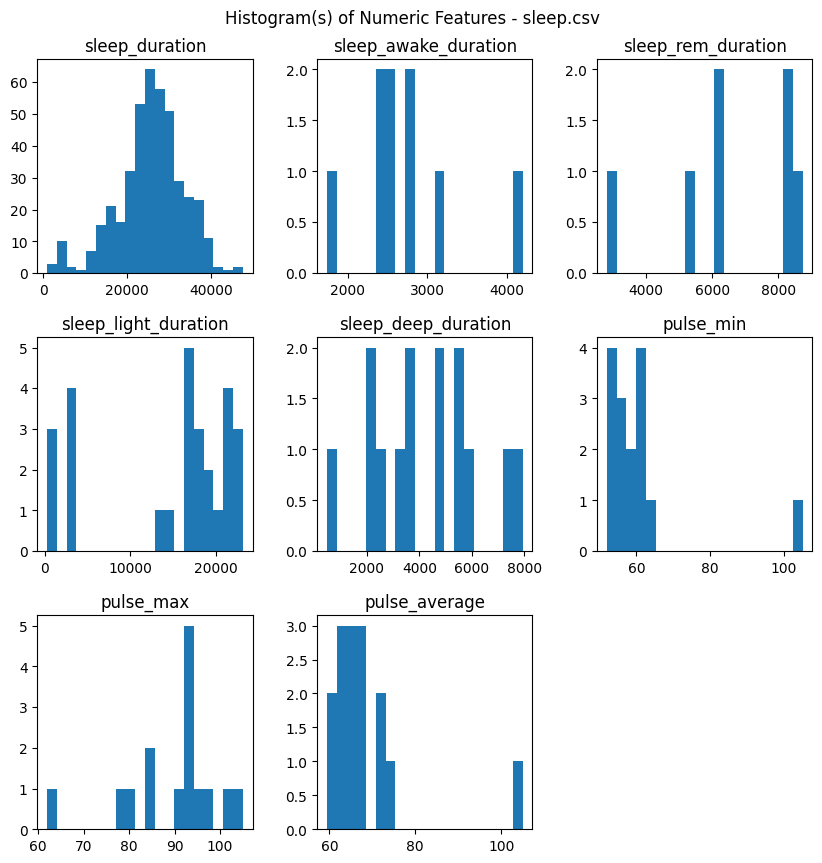

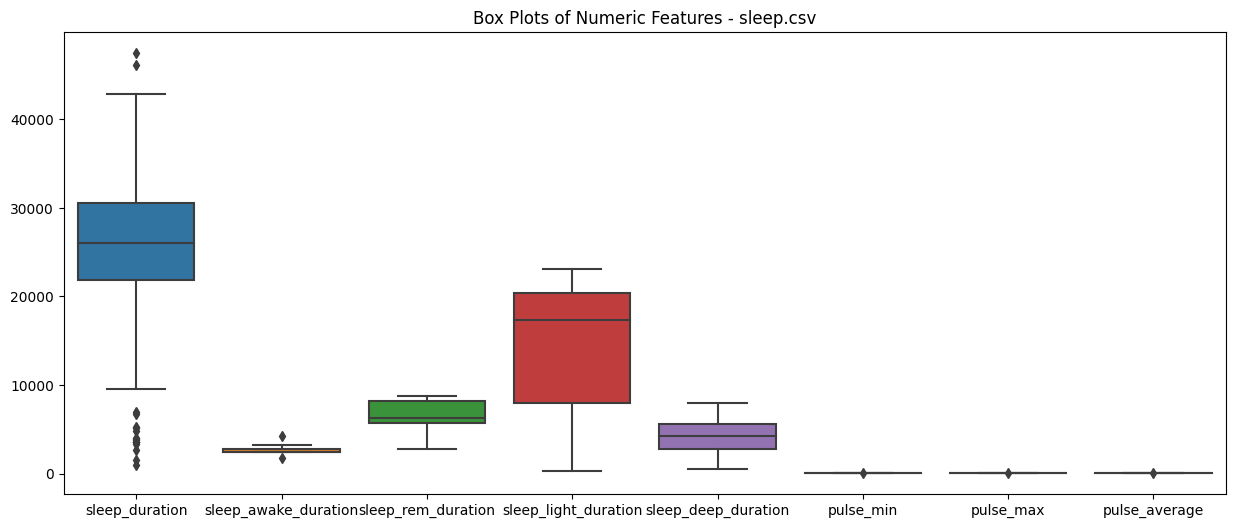

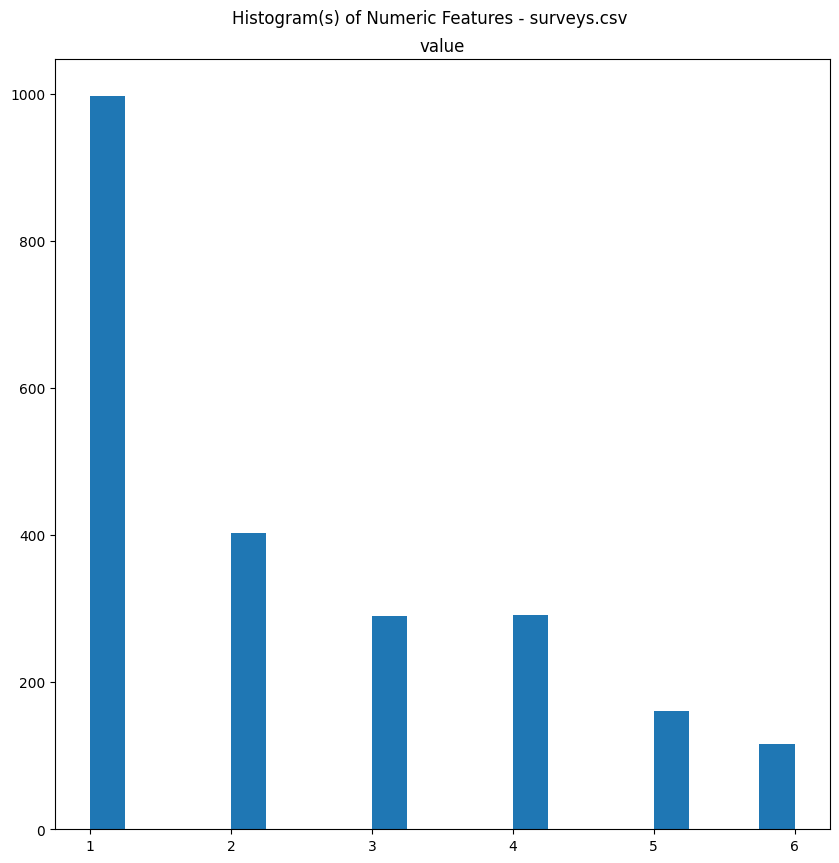

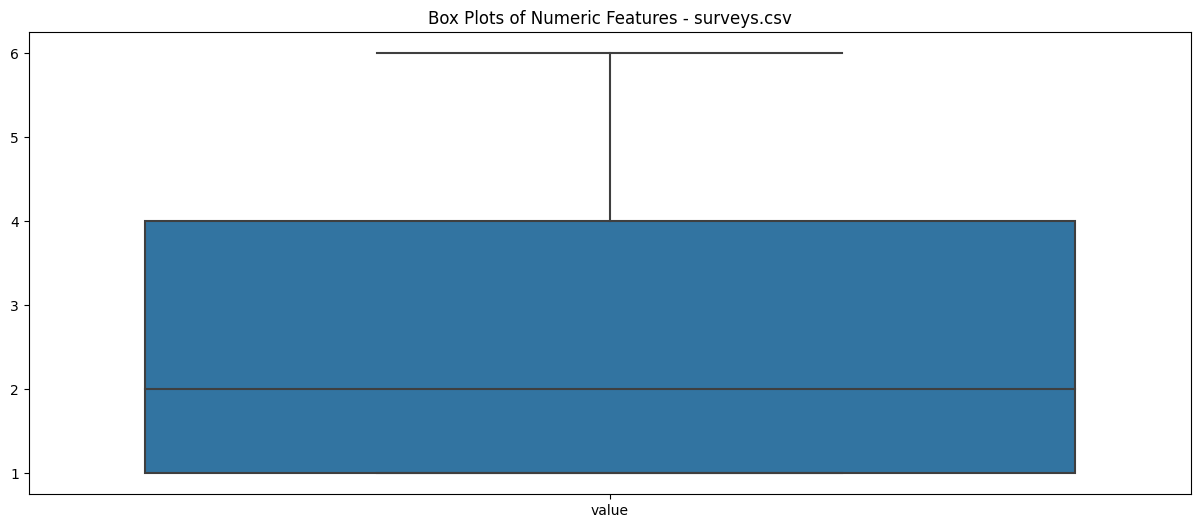

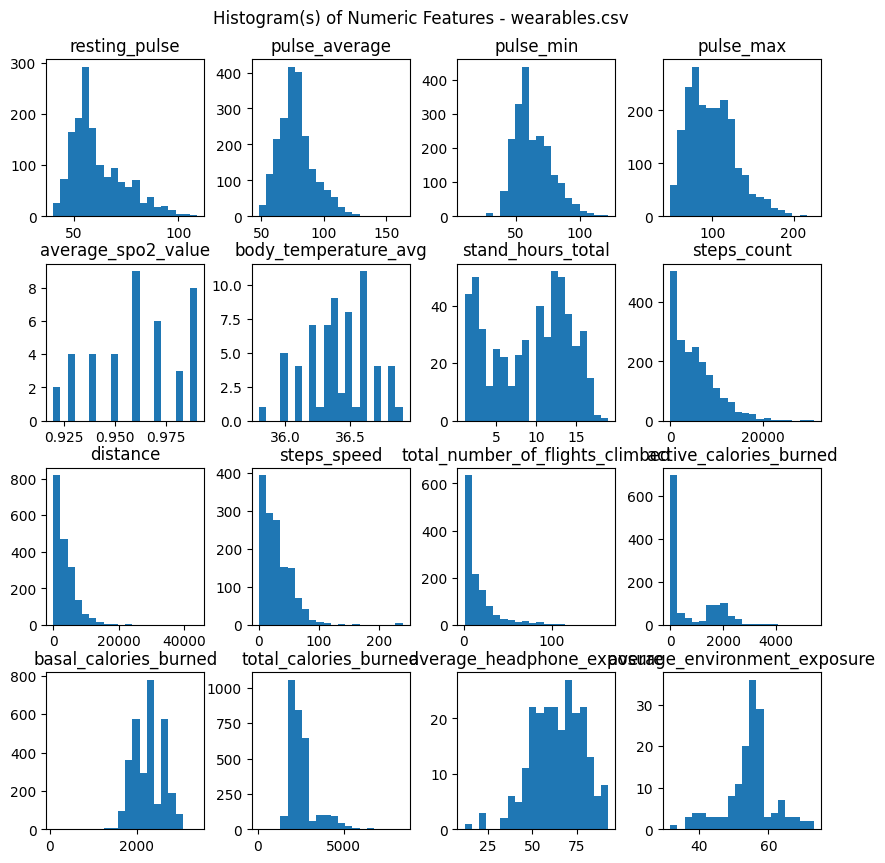

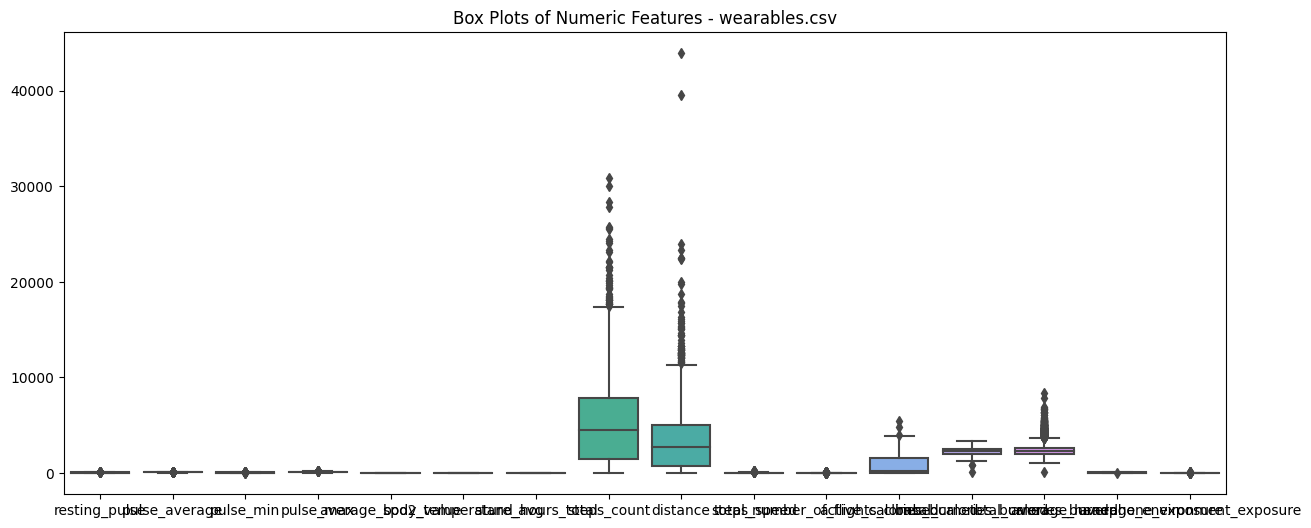

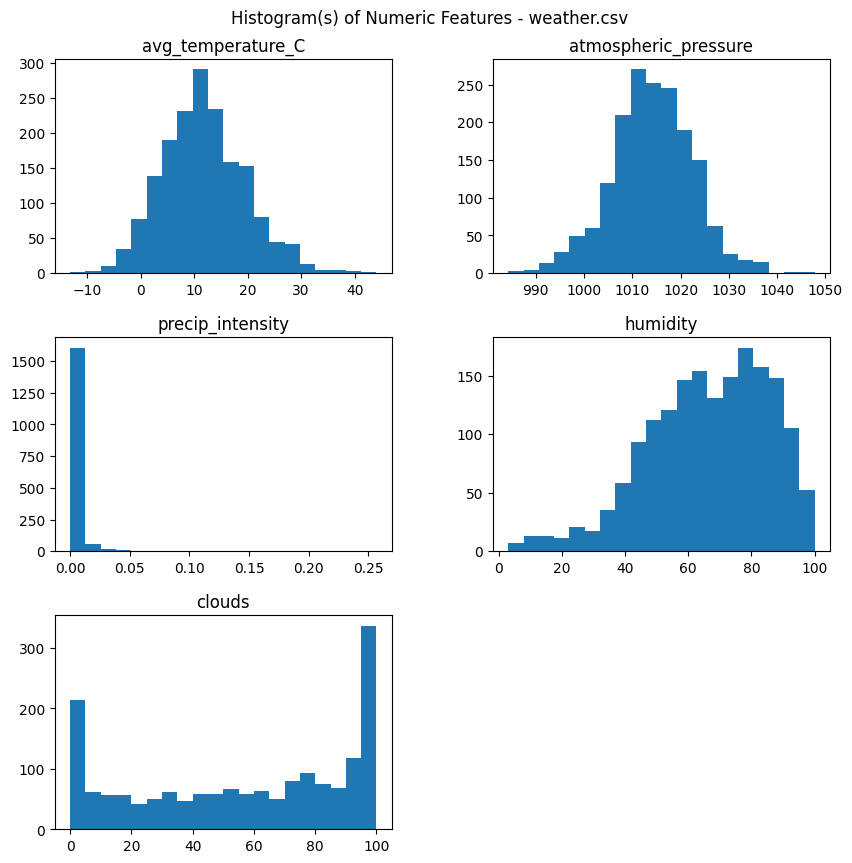

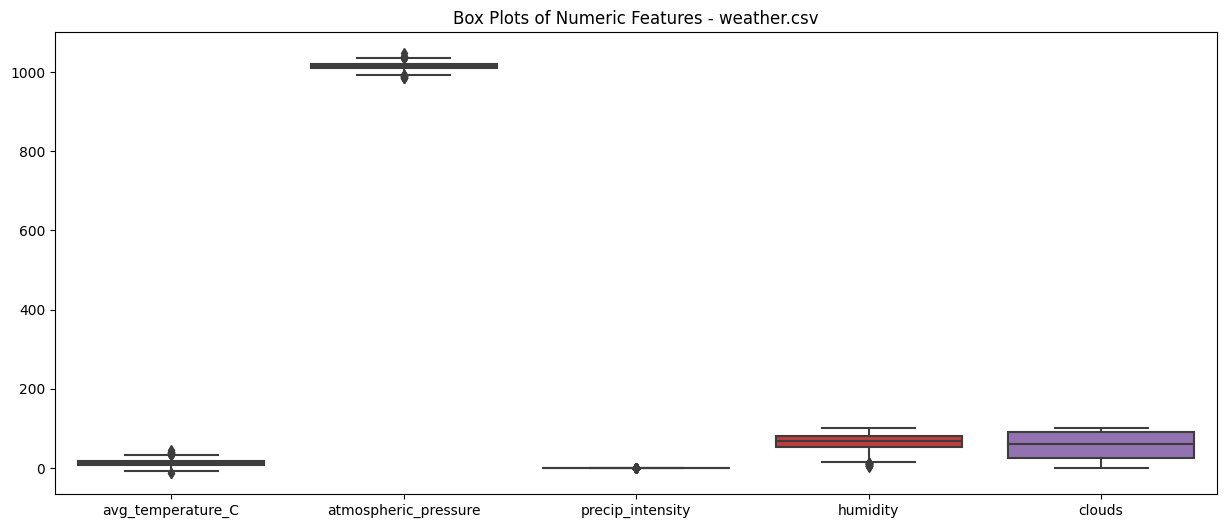

In [11]:
for df_name, df in dataframes.items():
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    # Visualize distributions
    df[numeric_columns].hist(bins=20, figsize=(10,10), grid=False)
    plt.suptitle(f'Histogram(s) of Numeric Features - {df_name}.csv', y=0.93)
    plt.show()

    # Box plots to identify outliers
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=df[numeric_columns])
    plt.title(f'Box Plots of Numeric Features - {df_name}.csv')
    plt.show()

### Interpretation
Some of the bar charts above revealed an obvious issue: not all numeric columns are on the same scale. For example, in `sleep.csv`, sleep duration in seconds is not on the same scale as average pulse. Below I'll highlight charts of interest and account for this scaling issue where necessary, beginning with the sleep duration columns from `sleep.csv`:

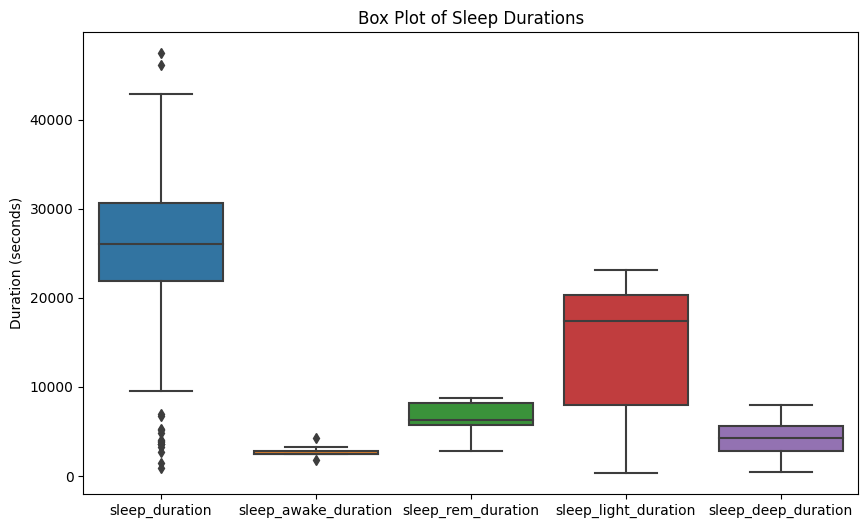

In [12]:
# Create dataframe that contains sleep duration fields only
sleep_df = dataframes["sleep"]
duration_columns = [col for col in sleep_df.columns if "duration" in col]
sleep_df[duration_columns]

# Generate box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=sleep_df[duration_columns])
plt.title('Box Plot of Sleep Durations')
plt.ylabel('Duration (seconds)')
plt.show()

As you can see, narrowing the box plot to sleep duration columns provides a clearer picture, which shows a significant number of outliers in the sleep duration column. It's possible these shorter duration measurements reflect naps instead of full night sleeps.

Another approach to dealing with numeric values that aren't on the same scale is normalization. The code below uses min-max normalization to reframe the `wearables.csv` box plot. The original `wearables.csv` plot included large values for `step_count` and `distance` but smaller values for columns such as `steps_speed` and `resting_pulse`. This made extracting meaningful information from the box plot difficult.

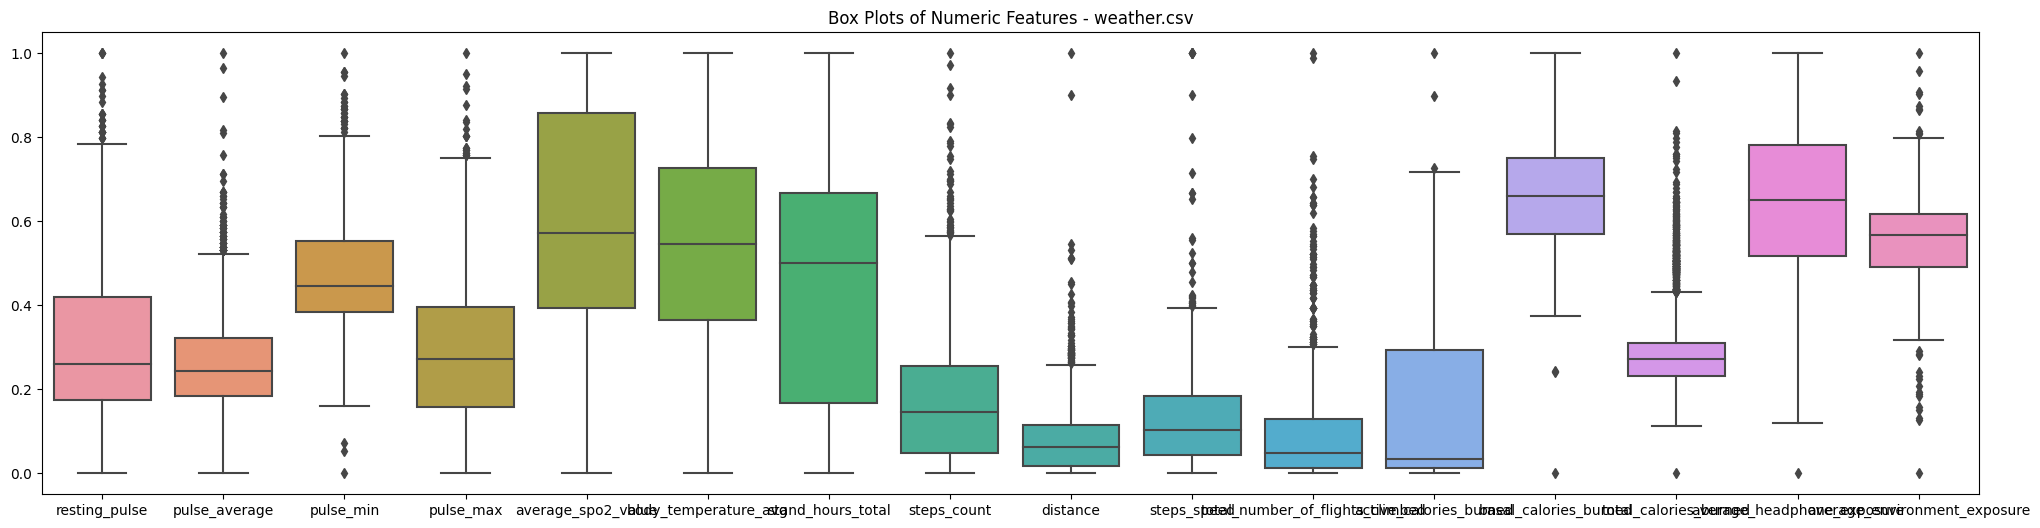

In [13]:
# Create a dataframe that contains the numeric columns from `wearables.csv`
wearables_df = dataframes["wearables"]
numeric_columns = wearables_df.select_dtypes(include=[np.number]).columns
df = wearables_df[numeric_columns]

# Normalize the dataframe using min/max
normalized_df=(df-df.min())/(df.max()-df.min())

# Generate box plot for the normalized data
plt.figure(figsize=(25, 6))
sns.boxplot(data=normalized_df)
plt.title(f'Box Plots of Numeric Features - {df_name}.csv')
plt.show()


Now that we have a properly scaled box plot, it becomes clear that numerous columns in `wearables.csv` contain outliers. For example, the `steps_count` and `distance` columns contain a significant number of outliers, which aligns with the fact that the standard deviation for those columns is roughly equal to the mean (see _Descriptive Statistics_ above). One strategy to reduce these outliers is discussed in the _Dimensionality Reduction_ section below.

As noted in the _Known Biases and Limitations_ section above, the dataset may underrepresent older participants due to the requirement for smartphone ownership and app usage. The bar chart below confirms the majority of participants (83%) fall within the 25-54 age range.

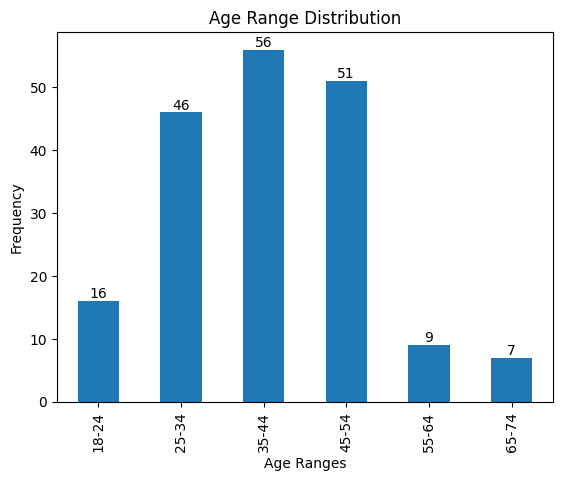

In [14]:
# Plot age range distribution
chart = dataframes["participants"]["age_range"].value_counts().sort_index().plot(
    kind="bar", title="Age Range Distribution", xlabel="Age Ranges", ylabel="Frequency")
chart.bar_label(chart.containers[0])
plt.show()

As mentioned previously, most participants in the study (70% of those that provided their country name) are from Russia or the United States. The code below produces a visulatization that illustrates the stark underrepresentation of other nationalities.

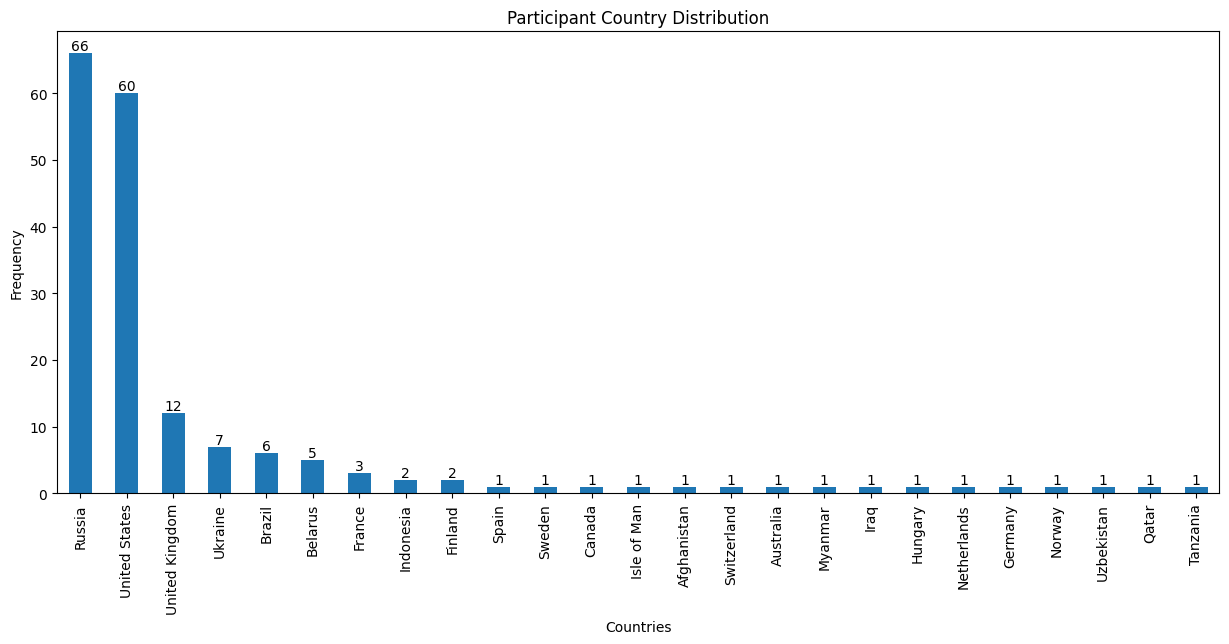

In [15]:
# Plot participant country distribution
plt.figure(figsize=(15, 6))
chart = dataframes["participants"]["country"].value_counts().plot(
    kind="bar", title="Participant Country Distribution", xlabel="Countries", ylabel="Frequency")
chart.bar_label(chart.containers[0])
plt.show()

Lastly, to demonstrate a strategy for reducing outliers, consider the histogram plot for the `circulatory_efficiency` feature from `blood_pressure.csv`:

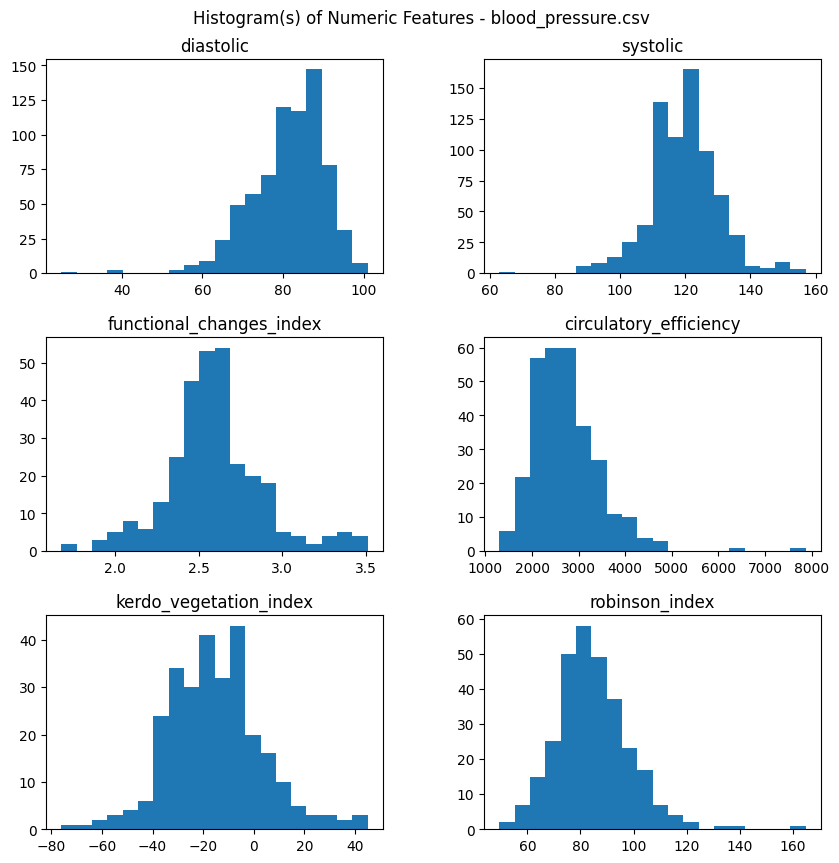

The chart above, as well as the corresponding box plot shown previously, highlight multiple outliers for this feature. The exact values of these outliers are shown using the following Python code:

In [26]:
dataframes["blood_pressure"].sort_values(by="circulatory_efficiency", ascending=False).head(10)

,user_code,measurement_datetime,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index
219,9871ee5e7b,2020-04-21 08:42:39,82,157,3.47,7875.0,22.0,164.85
54,276ab22485,2020-06-10 00:20:56,40,130,2.67,6390.0,44.0,92.30
203,7ba5381254,2020-04-17 03:21:27,90,148,3.43,4814.0,-8.0,122.84
575,cf7e50bcde,2020-05-05 21:53:27,57,102,2.37,4635.0,45.0,105.06
16,01bad5a519,2020-05-06 13:43:17,89,135,3.26,4600.0,11.0,135.00
2,01bad5a519,2020-04-30 09:16:38,95,140,3.38,4545.0,6.0,141.40
52,276ab22485,2020-05-07 15:02:45,66,132,2.87,4488.0,3.0,89.76
442,a1c2e6b2eb,2020-05-11 14:11:15,71,129,2.63,4350.0,5.0,96.75
470,a1c2e6b2eb,2020-05-15 19:54:50,68,122,2.57,4320.0,15.0,97.60
121,6be5033971,2020-04-21 15:16:00,71,124,2.64,4240.0,11.0,99.20


The table above shows the top two `circulatory_efficiency` values are significantly higher than the values that follow. To account for these outliers, one might consider reducing the outliers to a maximum value that is closer to "normal". This technique is known as clipping. For example, we might cap `circulatory_efficiency` at `4900` and reduce the two outliers to that value to avoid the outliers having an oversized impact on model training.

## Feature Engineering

### Transformations
As noted in the code present in the _Import the dataset_ section above, the following transformations were made when the dataset was imported:
* For `heart_rate.csv`, the `is_resting` column was converted to a Boolean value
* Multiple CSVs contained date and/or datetime columns that were transformed to the `np.datetime64` type to allow for easier analysis of those columns

### New Feature
The Python code below using the `height` and `weight` feature from `participants.csv` to add a new feature named `bmi`.

In [17]:
participants_df = dataframes["participants"]
# BMI = weight (kg) / height (m) squared; height must be converted from cm to meters
participants_df["bmi"] = participants_df["weight"] / ((participants_df["height"] / 100) ** 2)
participants_df

,user_code,gender,age_range,city,country,height,weight,symptoms_onset,bmi
0,007b8190cf,m,25-34,Mandalay,Myanmar,170.18,96.162,NaT,33.203698
1,013f6d3e5b,f,18-24,São Paulo,Brazil,174.00,77.300,2020-05-15,25.531774
2,01bad5a519,m,45-54,St Petersburg,Russia,178.00,92.000,2020-04-05,29.036738
3,0210b20eea,f,25-34,Sochi,Russia,169.00,60.000,2020-05-06,21.007668
4,024719e7da,f,45-54,St Petersburg,Russia,158.00,68.500,2020-05-27,27.439513
...,...,...,...,...,...,...,...,...,...
180,fd387f6269,f,35-44,Attleboro,United States,165.00,115.439,2020-05-01,42.401837
181,fdc881a0a8,f,55-64,Moscow,Russia,160.00,53.000,NaT,20.703125
182,fde84801d8,f,45-54,Tambov,Russia,168.00,79.500,2020-04-16,28.167517
183,fe5ca7e4ea,m,35-44,Dar es Salaam,Tanzania,168.00,87.500,NaT,31.001984


 With the addition of this new feature, we can categorize participants based on their BMI (e.g., underweight, healthy, etc.) and view the distribution.

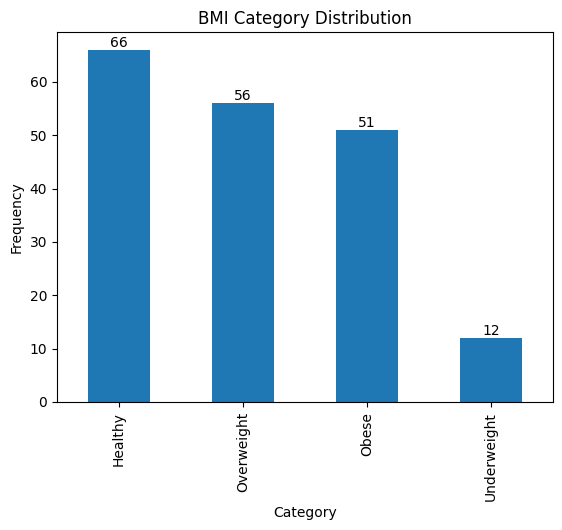

In [18]:
def label_bmi(row):
    if row["bmi"] < 18.5:
        return "Underweight"
    elif row["bmi"] <= 24.9:
        return "Healthy"
    elif row["bmi"] <= 29.9:
        return "Overweight"
    else:
        return "Obese"

# Create new column named `bmi_category` based on the BMI value
participants_df["bmi_category"] = participants_df.apply(label_bmi, axis=1)

# Plot BMI category distribution
chart = participants_df["bmi_category"].value_counts().plot(
    kind="bar", title="BMI Category Distribution", xlabel="Category", ylabel="Frequency")
chart.bar_label(chart.containers[0])
plt.show()


The new features, combined with the above visualization, provide a clearer picture of the overall health of participants.

### Dimensionality Reduction
To reduce the number of dimensions in the dataset, I examined values with high correlation. Let's take a closer look at the correlation heatmap for `wearables.csv`:

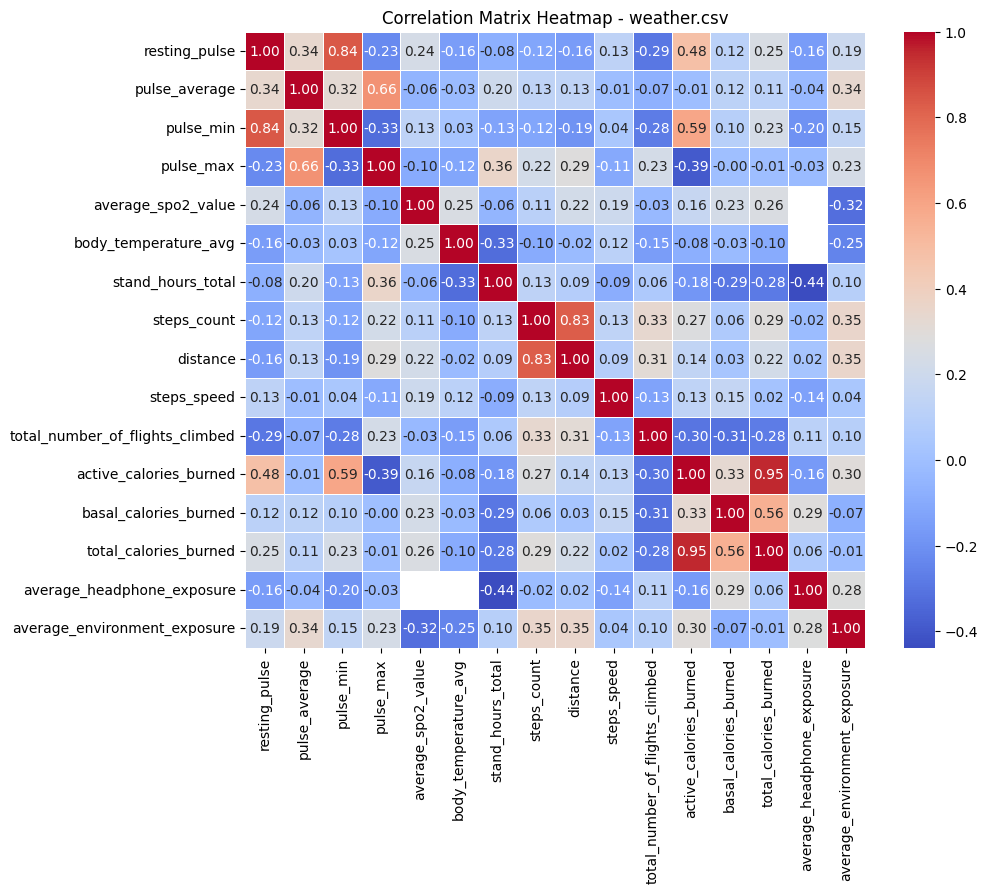

Notably, there is a high correlation (0.95) between `total_calories_burned` and `active_calories_burned`. The same is true for `steps_count` and `distance` (0.83). Because these values are so highly correlated, one might consider eliminating both the `active_calories_burned` feature and the `steps_count` feature since these values are inherently reflected in the `total_calories_burned` and `distance` features. The Python code below performs the dimensionality reduction.

In [19]:
# Remove the `active_calories_burned` and `steps_count` colums
dataframes["wearables"].drop(labels=["active_calories_burned", "steps_count"], axis=1, inplace=True)

# Display remaining column names
dataframes["wearables"].columns

Index(['user_code', 'day', 'resting_pulse', 'pulse_average', 'pulse_min', 'pulse_max', 'average_spo2_value', 'body_temperature_avg', 'stand_hours_total', 'distance', 'steps_speed', 'total_number_of_flights_climbed', 'basal_calories_burned', 'total_calories_burned', 'average_headphone_exposure', 'average_environment_exposure'], dtype='object')

## References
[1] https://welltory.com/our-story/

[2] [Pre-Emption of Affliction Severity Using HRV Measurements from a Smart Wearable; Case-Study on SARS-Cov-2 Symptoms](https://www.mdpi.com/1424-8220/20/24/7068)

[3] [Wearable Devices, Smartphones, and Interpretable Artificial Intelligence in Combating COVID-19](https://www.mdpi.com/1424-8220/21/24/8424)

[4] [Dataset Github: Hypotheses worth testing](https://github.com/Welltory/hrv-covid19?tab=readme-ov-file#hypotheses-worth-testing)

[5] [When Patients Recover From COVID-19: Data-Driven Insights From Wearable Technologies](https://www.frontiersin.org/journals/big-data/articles/10.3389/fdata.2022.801998/full)

[6] [Discussion on Humidity](https://www.weather.gov/lmk/humidity#:~:text=Warm%20air%20can%20possess%20more,if%20the%20air%20is%20warmer.)